# Required Imports and Constants

In [1]:
%matplotlib inline

import ast
import json
import os
import sys
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib import patches

from scipy.stats import f_oneway
from scipy.stats import ttest_1samp

import warnings
warnings.filterwarnings("ignore")


AYS_PIDS = [
      "0Odg8Ya9cQZM",
      "3Bl1l9qPo03v",
      "9BJDMrSg5GU2",
      "AtYKOM9xQoxo",
      "bvxCS2xslVD1",
      "bzdxtTFRW7bn",
      "Ck5zEa9jS8kr",
      "EPcW0vyMy901",
      "gzgUnyhhYvag",
      "kK7uC15Oxl7j",
      "WAiLZBXejqs6",
      "WBoN8OgUq9kM",
      "xrQxT9kE7trL",
]

SUM_PIDS = [
      "7YPaDt3k6zUJ",
      "9oAsM1Zsd2ZL",
      "BDsZoXY2KvCq",
      "cBx0ECEdnCXE",
      "DMMPwdh9JyIJ",
      "F8aaNjmqipm9",
      "iLi4QFTFUW6W",
      "KB4R9vQpgvDE",
      "n8dCqYoZqOtZ",
      "oa0dujnJJIQK",
      "Q3GODcr8rSU2",
      "Xb1da3tmq51s",
      "XK6R4nlN8DL9",
      "Xm4gLrMYjXLp",
]

RT_PIDS = [
      "3jCj03ExwbiR",
      "3LjPd26Bv20B",
      "7zspHOjpyZg6",
      "qBEgmP5F3go8",
      "RJozqLvmzUql",
      "SM3fpzR19vuY",
      "tqnTUO7mgIPw",
      "VSG8tghjg06Z",
      "wYKNw3brGUCM",
      "yJrWi90sw5Fv",
      "ZDOTBhGZ9oS9",
]

RTSUM_PIDS = [
      "1V7m8wY9JNak",
      "606gnDVdNwnt",
      "7UfOha66klmh",
      "DAn39rXtnCAS",
      "ggYz115dy0a9",
      "joO2OX6p9rr6",
      "rJwpqBcwhEar",
      "UPGk3s3Qldql",
      "vEiIrVSiezFn",
      "w6ptnTrqQi3D",
      "wJm4COpLVvz5",
      "zV0yHZRI3MH9"
]

ALL_PIDS = {
    'CTRL': AYS_PIDS,
    'SUM': SUM_PIDS,
    'RT': RT_PIDS,
    'RTSUM': RTSUM_PIDS,
}

# Ratio of Phase 2 Selections for Party and Gender - Compared Across Conditions - One-Way ANOVA + One-Sample t-Test

In [2]:
task = "politics"
choices = {
    'politics': {
        'gender': ['Male', 'Female'],
        'party': ['Republican', 'Democrat'],
    }
}
rows = []

for attribute, ratio_of in [('party', 'Democrat'), ('gender', 'Male')]:
    print(f"=== {attribute.capitalize()} - Ratio of {ratio_of}s Selected in Phase 2 ===")
    print()
    choices_zeros = pd.Series(
        [0.0 for _ in range(len(choices[task][attribute]))], 
        index=choices[task][attribute], 
        name=attribute
    )
    for condition in ["CTRL", "SUM", "RT", "RTSUM"]:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            basepath = os.path.join(condition, pid)  # basepath for PID
            try:
                df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                appOrder = "PM"
            except FileNotFoundError:
                df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                appOrder = "MP"

            drop_cols = [
                'selected',
                'timesVisited',
                'sizeVar',
                'xVar',
                'yVar',
                'jitter_x',
                'jitter_y',
            ]

            ### Get Ratio Of by Phase ###

            # Phase 1
            selection_phase_1 = (
                df[df['task'] == task]['selection_phase_1'].map(lambda x: ast.literal_eval(str(x)))
                    .apply(pd.Series).T[1]
                    .map(lambda x: ast.literal_eval(str(x)))
                    .apply(pd.Series)
                    .drop(columns=drop_cols)
                    .reset_index(drop=True)
            )
            attr_counts_phase_1 = (
                selection_phase_1[attribute].value_counts(normalize=True)
                    .append(choices_zeros)
                    .reset_index()
                    .drop_duplicates(subset='index', keep='first')
                    .set_index('index')[attribute]
            )

            # Phase 2
            selection_phase_2 = (
                df[df['task'] == task]['selection_phase_2'].map(lambda x: ast.literal_eval(str(x)))
                    .apply(pd.Series).T[1]
                    .map(lambda x: ast.literal_eval(str(x)))
                    .apply(pd.Series)
                    .drop(columns=drop_cols)
                    .reset_index(drop=True)
            )
            attr_counts_phase_2 = (
                selection_phase_2[attribute].value_counts(normalize=True)
                    .append(choices_zeros)
                    .reset_index()
                    .drop_duplicates(subset='index', keep='first')
                    .set_index('index')[attribute]
            )

            # Add to list of rows to create DataFrame from
            rows.append([pid, condition, attr_counts_phase_1.loc[ratio_of], attr_counts_phase_2.loc[ratio_of]])

    # Combine phase 1 and 2 into single dataframe
    df_ratio_of_by_phase = pd.DataFrame(
        rows,
        columns=['PID', 'Condition', 'Phase_1', 'Phase_2']
    )

    ### ACROSS ALL CONDITIONS
    
    print('Across all conditions => {CTRL, SUM, RT, RTSUM}')
    print('-----------------------------------------------')

    # Show 5 number summary
    print(df_ratio_of_by_phase.groupby('Condition')['Phase_2'].describe())
    print()

    # Perform ANOVA 1-way test
    vals = df_ratio_of_by_phase.groupby('Condition')['Phase_2'].apply(list).tolist()
    f_stat, p_val = f_oneway(*vals)
    print(f"One-Way ANOVA\t|\tGroups: Condition\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
    print()

    ### BETWEEN CONTROL AND INTERVENTION ###
    
    print('Between CTRL (CONTROL) and SUM + RT + RTSUM (INTERVENTION) conditions')
    print('---------------------------------------------------------------------')

    # Show 5 number summary
    print(
        df_ratio_of_by_phase.replace(['SUM', 'RT', 'RTSUM'], 'INTV')
            .groupby('Condition')['Phase_2']
            .describe()
    )
    print()

    # Compare to baseline ratios
    vals = df_ratio_of_by_phase.replace(['SUM', 'RT', 'RTSUM'], 'INTV').groupby('Condition')['Phase_2'].apply(list)
    print(f"One-Sample t-TEST | Within each condition")
    if ratio_of == "Male":
        print(f"Expected Mean: 0.68")
        print()
        t_stat, p_val = ttest_1samp(vals['CTRL'], 0.68)
        print(f"CONTROL\t|\tT Statistic: {t_stat:.04f}\t|\tp-value: {p_val:.08f}")
        t_stat, p_val = ttest_1samp(vals['INTV'], 0.68)
        print(f"INTERV\t|\tT Statistic: {t_stat:.04f}\t|\tp-value: {p_val:.08f}")
    elif ratio_of == "Democrat":
        print(f"Expected Mean: 0.41")
        print()
        t_stat, p_val = ttest_1samp(vals['CTRL'], 0.41)
        print(f"CONTROL\t|\tT Statistic: {t_stat:.04f}\t|\tp-value: {p_val:.08f}")
        t_stat, p_val = ttest_1samp(vals['INTV'], 0.41)
        print(f"INTERV\t|\tT Statistic: {t_stat:.04f}\t|\tp-value: {p_val:.08f}")
    print()
    print()

=== Party - Ratio of Democrats Selected in Phase 2 ===

Across all conditions => {CTRL, SUM, RT, RTSUM}
-----------------------------------------------
           count      mean       std  min    25%  50%    75%  max
Condition                                                        
CTRL        13.0  0.553846  0.338170  0.0  0.400  0.5  0.800  1.0
RT          11.0  0.645455  0.317376  0.0  0.450  0.7  0.900  1.0
RTSUM       12.0  0.683333  0.240580  0.4  0.500  0.6  0.925  1.0
SUM         14.0  0.714286  0.391952  0.0  0.625  0.9  1.000  1.0

One-Way ANOVA	|	Groups: Condition	|	F Statistic: 0.5860	|	p-value: 0.6272

Between CTRL (CONTROL) and SUM + RT + RTSUM (INTERVENTION) conditions
---------------------------------------------------------------------
           count      mean       std  min  25%  50%  75%  max
Condition                                                    
CTRL        13.0  0.553846  0.338170  0.0  0.4  0.5  0.8  1.0
INTV        37.0  0.683784  0.319299  0.0  0.5  0.

# Ratio of Males Selected plotted by Phase 1 and 2 - Across CONTROL / INTERVENTION Conditions

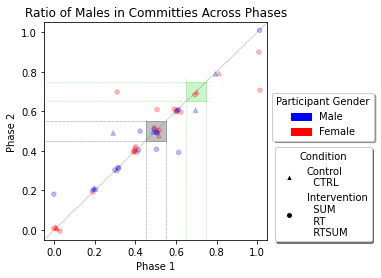

In [3]:
task = "politics"
attribute = 'gender'
ratio_of = 'Male'
choices = {
    'politics': {
        'gender': ['Male', 'Female'],
        'party': ['Republican', 'Democrat'],
    }
}
choices_zeros = pd.Series(
    [0.0 for _ in range(len(choices[task][attribute]))], 
    index=choices[task][attribute], 
    name=attribute
)
rows = []

### Participant Gender/Party ###

df_background = (
    pd.read_excel("Qualtrics/CLEAN/Background.xlsx", engine='openpyxl')
        .rename(
            columns={
                "LRG ID": "PID",
                "With which gender identity do you most identify? - Selected Choice": "gender",               }
        )[['PID', 'gender']]
)

df_pre_survey = (
    pd.read_excel("Qualtrics/CLEAN/Pre-Survey-Politics.xlsx", engine='openpyxl')
        .rename(
            columns={
                "LRG ID": "PID",
                "Candidates from which political party are you most likely to vote for in the next US political election?": "party",
            }
        )[['PID', 'party']]
)

### Participant Selections ###

for condition in ["CTRL", "SUM", "RT", "RTSUM"]:
    PIDS = ALL_PIDS[condition]
    for pid in PIDS:
        basepath = os.path.join(condition, pid)  # basepath for PID
        try:
            df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
            appOrder = "PM"
        except FileNotFoundError:
            df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
            appOrder = "MP"

        drop_cols = [
            'selected',
            'timesVisited',
            'sizeVar',
            'xVar',
            'yVar',
            'jitter_x',
            'jitter_y',
        ]

        ### Get Ratio Of by Phase ###

        # Phase 1
        selection_phase_1 = (
            df[df['task'] == task]['selection_phase_1'].map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series).T[1]
                .map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series)
                .drop(columns=drop_cols)
                .reset_index(drop=True)
        )
        attr_counts_phase_1 = (
            selection_phase_1[attribute].value_counts(normalize=True)
                .append(choices_zeros)
                .reset_index()
                .drop_duplicates(subset='index', keep='first')
                .set_index('index')[attribute]
        )

        # Phase 2
        selection_phase_2 = (
            df[df['task'] == task]['selection_phase_2'].map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series).T[1]
                .map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series)
                .drop(columns=drop_cols)
                .reset_index(drop=True)
        )
        attr_counts_phase_2 = (
            selection_phase_2[attribute].value_counts(normalize=True)
                .append(choices_zeros)
                .reset_index()
                .drop_duplicates(subset='index', keep='first')
                .set_index('index')[attribute]
        )

        # Add to list of rows to create DataFrame from
        rows.append(
            [pid, condition, attr_counts_phase_1.loc[ratio_of], attr_counts_phase_2.loc[ratio_of]]
        )

# Combine phase 1 and 2 into single dataframe
df_ratio_of_by_phase = (
    pd.DataFrame(
        rows,
        columns=['PID', 'Condition', 'Phase 1', 'Phase 2']
    )
    .set_index('PID')
    .join(df_background.set_index('PID'))
    .join(df_pre_survey.set_index('PID'))
    .reset_index()[['PID', 'gender', 'party', 'Condition', 'Phase 1', 'Phase 2']]
)

# Plot results
fig, ax_curr = plt.subplots(1, 1, figsize=(4,4))

plot_config = {
    'marker': {
        'CTRL': '^',
        'SUM': 'o',
        'RT': 'o',
        'RTSUM': 'o',
    },
    'color': {
        'gender': {
            'Male': 'b',
            'Female': 'r',
            'agender': 'w',
        },
        'party': {
            'Democratic': 'b',
            'Republican': 'r',
        },
    }   
}


for key, grp in df_ratio_of_by_phase.groupby(['Condition']):
    ax_curr.set_xlim([-0.05, 1.05])
    ax_curr.set_ylim([-0.05, 1.05])

    # Jitter x
    stdev_x = .0125 * (grp['Phase 1'].max() - grp['Phase 1'].min())
    grp['Phase 1'] += np.random.randn(len(grp['Phase 1'].index)) * stdev_x

    # Jitter y
    stdev_x = .0125 * (grp['Phase 2'].max() - grp['Phase 2'].min())
    grp['Phase 2'] += np.random.randn(len(grp['Phase 2'].index)) * stdev_x

    grp.plot.scatter(
        ax=ax_curr, 
        x='Phase 1', 
        y='Phase 2', 
        c=[plot_config['color'][attribute][val] for val in grp[attribute]], 
        marker=plot_config['marker'][key],
        alpha=0.25, 
        title=f'Ratio of {ratio_of}s in Committies Across Phases', 
        zorder=10
    )

    # diagonal
    ax_curr.plot(
        [0, 1], [0, 1], transform=ax_curr.transAxes, linestyle=':', linewidth=0.5, color="grey", alpha=0.5
    )

    # equal selection shaded
    ax_curr.axvline(0.45, ymax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.axvline(0.55, ymax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.axhline(0.45, xmax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.axhline(0.55, xmax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.fill_between([0.45, 0.55], 0.45, 0.55, alpha=0.15, color='grey')

    # proportial selection shaded
    if ratio_of == 'Democrat':
        ax_curr.axvline(0.35, ymax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axvline(0.45, ymax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.35, xmax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.45, xmax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.fill_between([0.35, 0.45], 0.35, 0.45, alpha=0.15, color='lightgreen')
    elif ratio_of == 'Male':
        ax_curr.axvline(0.65, ymax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axvline(0.75, ymax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.65, xmax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.75, xmax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.fill_between([0.65, 0.75], 0.65, 0.75, alpha=0.15, color='lightgreen')

# Legend 1
labels = [{'gender': 'Male', 'party': 'Democrat'}, {'gender': 'Female', 'party': 'Republican'}]
male_dem_its = patches.Patch(color='blue')
fem_rep_its = patches.Patch(color='red')
handles1 = [male_dem_its, fem_rep_its]
labels1 = [labels[0][attribute], labels[1][attribute]]
legend1 = plt.legend(handles1, labels1, title=f'Participant {attribute.capitalize()}', loc='upper center', 
                  bbox_to_anchor=(1.25, 0.7), fancybox=True, shadow=True, ncol=1)

# Legend 2
control_marker = lines.Line2D(range(1), range(1), color="white", marker='^', markerfacecolor="black")
intervention_marker = lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="black")
handles2 = [control_marker, intervention_marker]
labels2 = ['Control\n  CTRL', 'Intervention\n  SUM\n  RT\n  RTSUM']
legend2 = plt.legend(handles2, labels2, title='Condition', loc='upper center', 
                  bbox_to_anchor=(1.25, 0.45), fancybox=True, shadow=True, ncol=1)

ax_curr.add_artist(legend1)
ax_curr.add_artist(legend2)

#     plt.savefig(f'charts/selection/{attribute}_ratio_{ratio_of}.png', dpi=300, bbox_inches='tight')

# Ratio of Democrats Selected plotted by Phase 1 and 2 - Across CONTROL / INTERVENTION Conditions

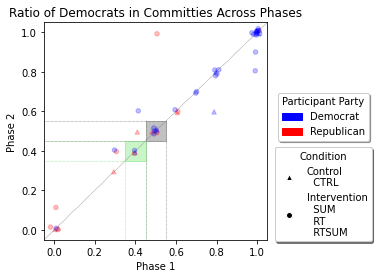

In [4]:
task = "politics"
attribute = 'party'
ratio_of = 'Democrat'
choices = {
    'politics': {
        'gender': ['Male', 'Female'],
        'party': ['Republican', 'Democrat'],
    }
}
choices_zeros = pd.Series(
    [0.0 for _ in range(len(choices[task][attribute]))], 
    index=choices[task][attribute], 
    name=attribute
)
rows = []

### Participant Gender/Party ###

df_background = (
    pd.read_excel("Qualtrics/CLEAN/Background.xlsx", engine='openpyxl')
        .rename(
            columns={
                "LRG ID": "PID",
                "With which gender identity do you most identify? - Selected Choice": "gender",               }
        )[['PID', 'gender']]
)

df_pre_survey = (
    pd.read_excel("Qualtrics/CLEAN/Pre-Survey-Politics.xlsx", engine='openpyxl')
        .rename(
            columns={
                "LRG ID": "PID",
                "Candidates from which political party are you most likely to vote for in the next US political election?": "party",
            }
        )[['PID', 'party']]
)

### Participant Selections ###

for condition in ["CTRL", "SUM", "RT", "RTSUM"]:
    PIDS = ALL_PIDS[condition]
    for pid in PIDS:
        basepath = os.path.join(condition, pid)  # basepath for PID
        try:
            df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
            appOrder = "PM"
        except FileNotFoundError:
            df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
            appOrder = "MP"

        drop_cols = [
            'selected',
            'timesVisited',
            'sizeVar',
            'xVar',
            'yVar',
            'jitter_x',
            'jitter_y',
        ]

        ### Get Ratio Of by Phase ###

        # Phase 1
        selection_phase_1 = (
            df[df['task'] == task]['selection_phase_1'].map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series).T[1]
                .map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series)
                .drop(columns=drop_cols)
                .reset_index(drop=True)
        )
        attr_counts_phase_1 = (
            selection_phase_1[attribute].value_counts(normalize=True)
                .append(choices_zeros)
                .reset_index()
                .drop_duplicates(subset='index', keep='first')
                .set_index('index')[attribute]
        )

        # Phase 2
        selection_phase_2 = (
            df[df['task'] == task]['selection_phase_2'].map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series).T[1]
                .map(lambda x: ast.literal_eval(str(x)))
                .apply(pd.Series)
                .drop(columns=drop_cols)
                .reset_index(drop=True)
        )
        attr_counts_phase_2 = (
            selection_phase_2[attribute].value_counts(normalize=True)
                .append(choices_zeros)
                .reset_index()
                .drop_duplicates(subset='index', keep='first')
                .set_index('index')[attribute]
        )

        # Add to list of rows to create DataFrame from
        rows.append(
            [pid, condition, attr_counts_phase_1.loc[ratio_of], attr_counts_phase_2.loc[ratio_of]]
        )

# Combine phase 1 and 2 into single dataframe
df_ratio_of_by_phase = (
    pd.DataFrame(
        rows,
        columns=['PID', 'Condition', 'Phase 1', 'Phase 2']
    )
    .set_index('PID')
    .join(df_background.set_index('PID'))
    .join(df_pre_survey.set_index('PID'))
    .reset_index()[['PID', 'gender', 'party', 'Condition', 'Phase 1', 'Phase 2']]
)

# Plot results
fig, ax_curr = plt.subplots(1, 1, figsize=(4,4))

plot_config = {
    'marker': {
        'CTRL': '^',
        'SUM': 'o',
        'RT': 'o',
        'RTSUM': 'o',
    },
    'color': {
        'gender': {
            'Male': 'b',
            'Female': 'r',
            'agender': 'w',
        },
        'party': {
            'Democratic': 'b',
            'Republican': 'r',
        },
    }   
}


for key, grp in df_ratio_of_by_phase.groupby(['Condition']):
    ax_curr.set_xlim([-0.05, 1.05])
    ax_curr.set_ylim([-0.05, 1.05])

    # Jitter x
    stdev_x = .0125 * (grp['Phase 1'].max() - grp['Phase 1'].min())
    grp['Phase 1'] += np.random.randn(len(grp['Phase 1'].index)) * stdev_x

    # Jitter y
    stdev_x = .0125 * (grp['Phase 2'].max() - grp['Phase 2'].min())
    grp['Phase 2'] += np.random.randn(len(grp['Phase 2'].index)) * stdev_x

    grp.plot.scatter(
        ax=ax_curr, 
        x='Phase 1', 
        y='Phase 2', 
        c=[plot_config['color'][attribute][val] for val in grp[attribute]], 
        marker=plot_config['marker'][key],
        alpha=0.25, 
        title=f'Ratio of {ratio_of}s in Committies Across Phases', 
        zorder=10
    )

    # diagonal
    ax_curr.plot(
        [0, 1], [0, 1], transform=ax_curr.transAxes, linestyle=':', linewidth=0.5, color="grey", alpha=0.5
    )

    # equal selection shaded
    ax_curr.axvline(0.45, ymax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.axvline(0.55, ymax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.axhline(0.45, xmax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.axhline(0.55, xmax=0.55, linestyle=":", linewidth=0.5, color="grey", alpha=0.5)
    ax_curr.fill_between([0.45, 0.55], 0.45, 0.55, alpha=0.15, color='grey')

    # proportial selection shaded
    if ratio_of == 'Democrat':
        ax_curr.axvline(0.35, ymax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axvline(0.45, ymax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.35, xmax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.45, xmax=0.45, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.fill_between([0.35, 0.45], 0.35, 0.45, alpha=0.15, color='lightgreen')
    elif ratio_of == 'Male':
        ax_curr.axvline(0.65, ymax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axvline(0.75, ymax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.65, xmax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.axhline(0.75, xmax=0.75, linestyle=":", linewidth=0.5, color="lightgreen", alpha=0.5)
        ax_curr.fill_between([0.65, 0.75], 0.65, 0.75, alpha=0.15, color='lightgreen')

# Legend 1
labels = [{'gender': 'Male', 'party': 'Democrat'}, {'gender': 'Female', 'party': 'Republican'}]
male_dem_its = patches.Patch(color='blue')
fem_rep_its = patches.Patch(color='red')
handles1 = [male_dem_its, fem_rep_its]
labels1 = [labels[0][attribute], labels[1][attribute]]
legend1 = plt.legend(handles1, labels1, title=f'Participant {attribute.capitalize()}', loc='upper center', 
                  bbox_to_anchor=(1.25, 0.7), fancybox=True, shadow=True, ncol=1)

# Legend 2
control_marker = lines.Line2D(range(1), range(1), color="white", marker='^', markerfacecolor="black")
intervention_marker = lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="black")
handles2 = [control_marker, intervention_marker]
labels2 = ['Control\n  CTRL', 'Intervention\n  SUM\n  RT\n  RTSUM']
legend2 = plt.legend(handles2, labels2, title='Condition', loc='upper center', 
                  bbox_to_anchor=(1.25, 0.45), fancybox=True, shadow=True, ncol=1)

ax_curr.add_artist(legend1)
ax_curr.add_artist(legend2)

#     plt.savefig(f'charts/selection/{attribute}_ratio_{ratio_of}.png', dpi=300, bbox_inches='tight')